In [4]:
import sys
sys.path.append('../../..')

from olfactory_navigation import Environment, Agent
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.simulation import run_test, SimulationHistory
from olfactory_navigation.test_setups import run_all_starts_test

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import cupy as cp

In [5]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

## Parameters

In [32]:
tank_size = np.array([111,142]) # actual size: 114cm x 89cm but it is scaled by a walking speed of 0.8 cm/s
space_shape = (tank_size * 2) + 1

goal_radius = 1
odor_radius = 3.75 # 3 cm * 0.8 -> 3.75 grid units

In [33]:
odor_field = np.zeros(space_shape)
odor_field_indices = np.array(list(np.ndindex(tuple(space_shape))))

in_odor_plume = np.sum((odor_field_indices - tank_size[None,:])**2, axis=1) <= (odor_radius ** 2)
odor_field[*odor_field_indices[in_odor_plume].T] = 1.0

## Building model

In [40]:
env = Environment(data_file=odor_field[None,:,:],
                  data_source_position=tank_size,
                  source_radius=goal_radius)

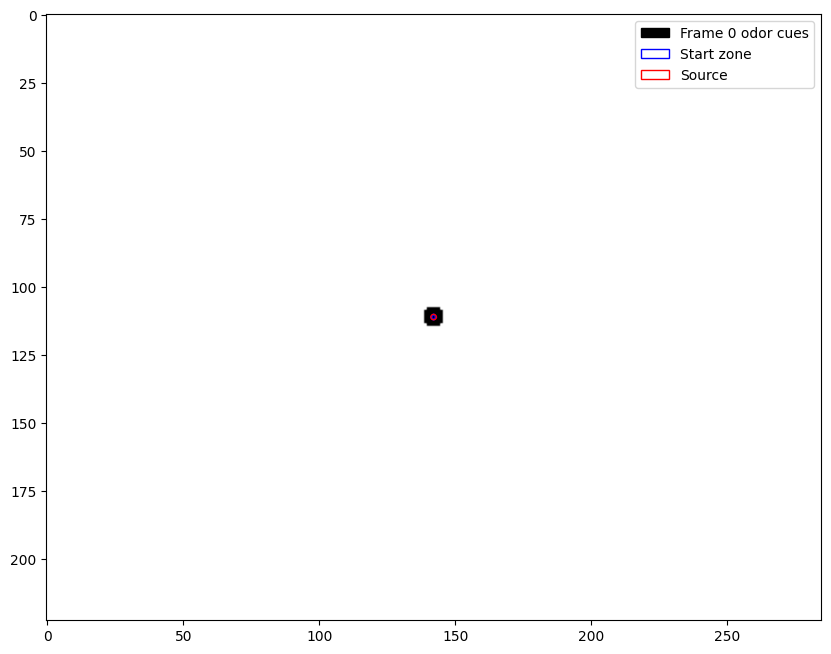

In [41]:
_,ax = plt.subplots(1,1, figsize=(10,10))
env.plot(ax=ax)

## Agent Training

In [ ]:
ag = FSVI_Agent(env)
_ = ag.train(expansions=300,
             eps=-np.inf,
             use_gpu=True)

[11/11/2024, 14:48:58] MDP_policy, not provided. Solving MDP with Value Iteration...
[11/11/2024, 14:48:58] Sending Model to GPU...
[11/11/2024, 14:48:58]     > Done in 0.004s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 63555-state, 4-action
  - Converged in 1000 iterations and 2.6649 seconds
  - Took on average 0.0027s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Memory full: Out of memory allocating 2,489,322,496 bytes (allocated so far: 8,839,241,728 bytes).
Returning value function and history as is...

Summary of Point Based Value Iteration run
  - Model: 63555 state, 4 action, 3 observations
  - Converged or stopped after 179 expansion steps and 178 backup steps.
  - Resulting value function has 408 alpha vectors.
  - Converged in 276.0181s

  - Expand function took on average 0.0139s and yielded on average 48.92 beliefs per iteration. (0.0004s/it/belief)
  - Backup function took on average 1.5367s and yielded on average 2.27 alpha vectors per iteration. (0.0082s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


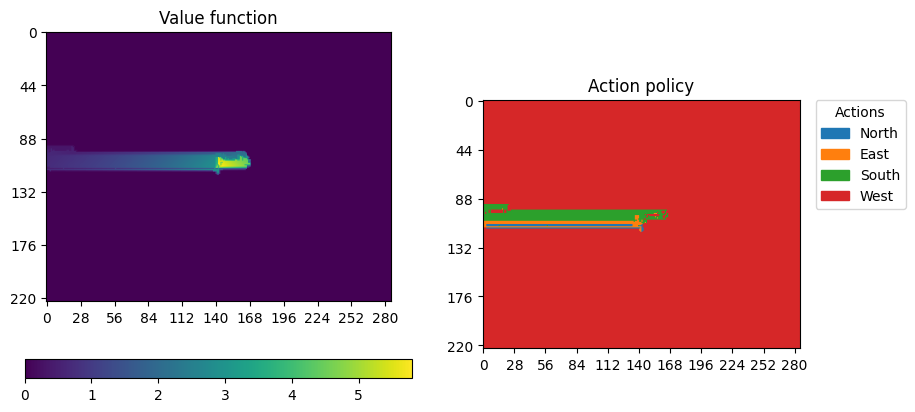

In [45]:
ag.value_function.plot()